In [1]:
import tensorflow as tf

# IMPORTANTE: Dejad este conjunto de lineas #
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#############################################

Num GPUs Available:  2


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [3]:
datapath = "data/pvpcdata.csv"
day = 24

In [4]:
df = pd.read_csv(datapath, sep = ";")

In [5]:
#Due to the hour format is between 0 to 23, we need to transform it
for i in df.index:
        df.at[i, 'hour'] = df.at[i, 'hour'] - 1

In [6]:
#To keep only valid valued, not the unusual ones
df = df.loc[df['hour'] < 24]

In [7]:
cols = ["year","month","day"]
df['date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

In [8]:
df.head()

,year,month,day,hour,price,date
0,2017,1,1,0,58.82,2017-1-1
1,2017,1,1,1,58.23,2017-1-1
2,2017,1,1,2,51.95,2017-1-1
3,2017,1,1,3,47.27,2017-1-1
4,2017,1,1,4,46.90,2017-1-1


In [9]:
df['date'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['hour'].astype(str) + ":00:00")

In [10]:
df = df.loc[df.date >= '2022-01-01 00:00:00']

[Text(0.5, 1.0, 'Energy prices per hour at the last day')]

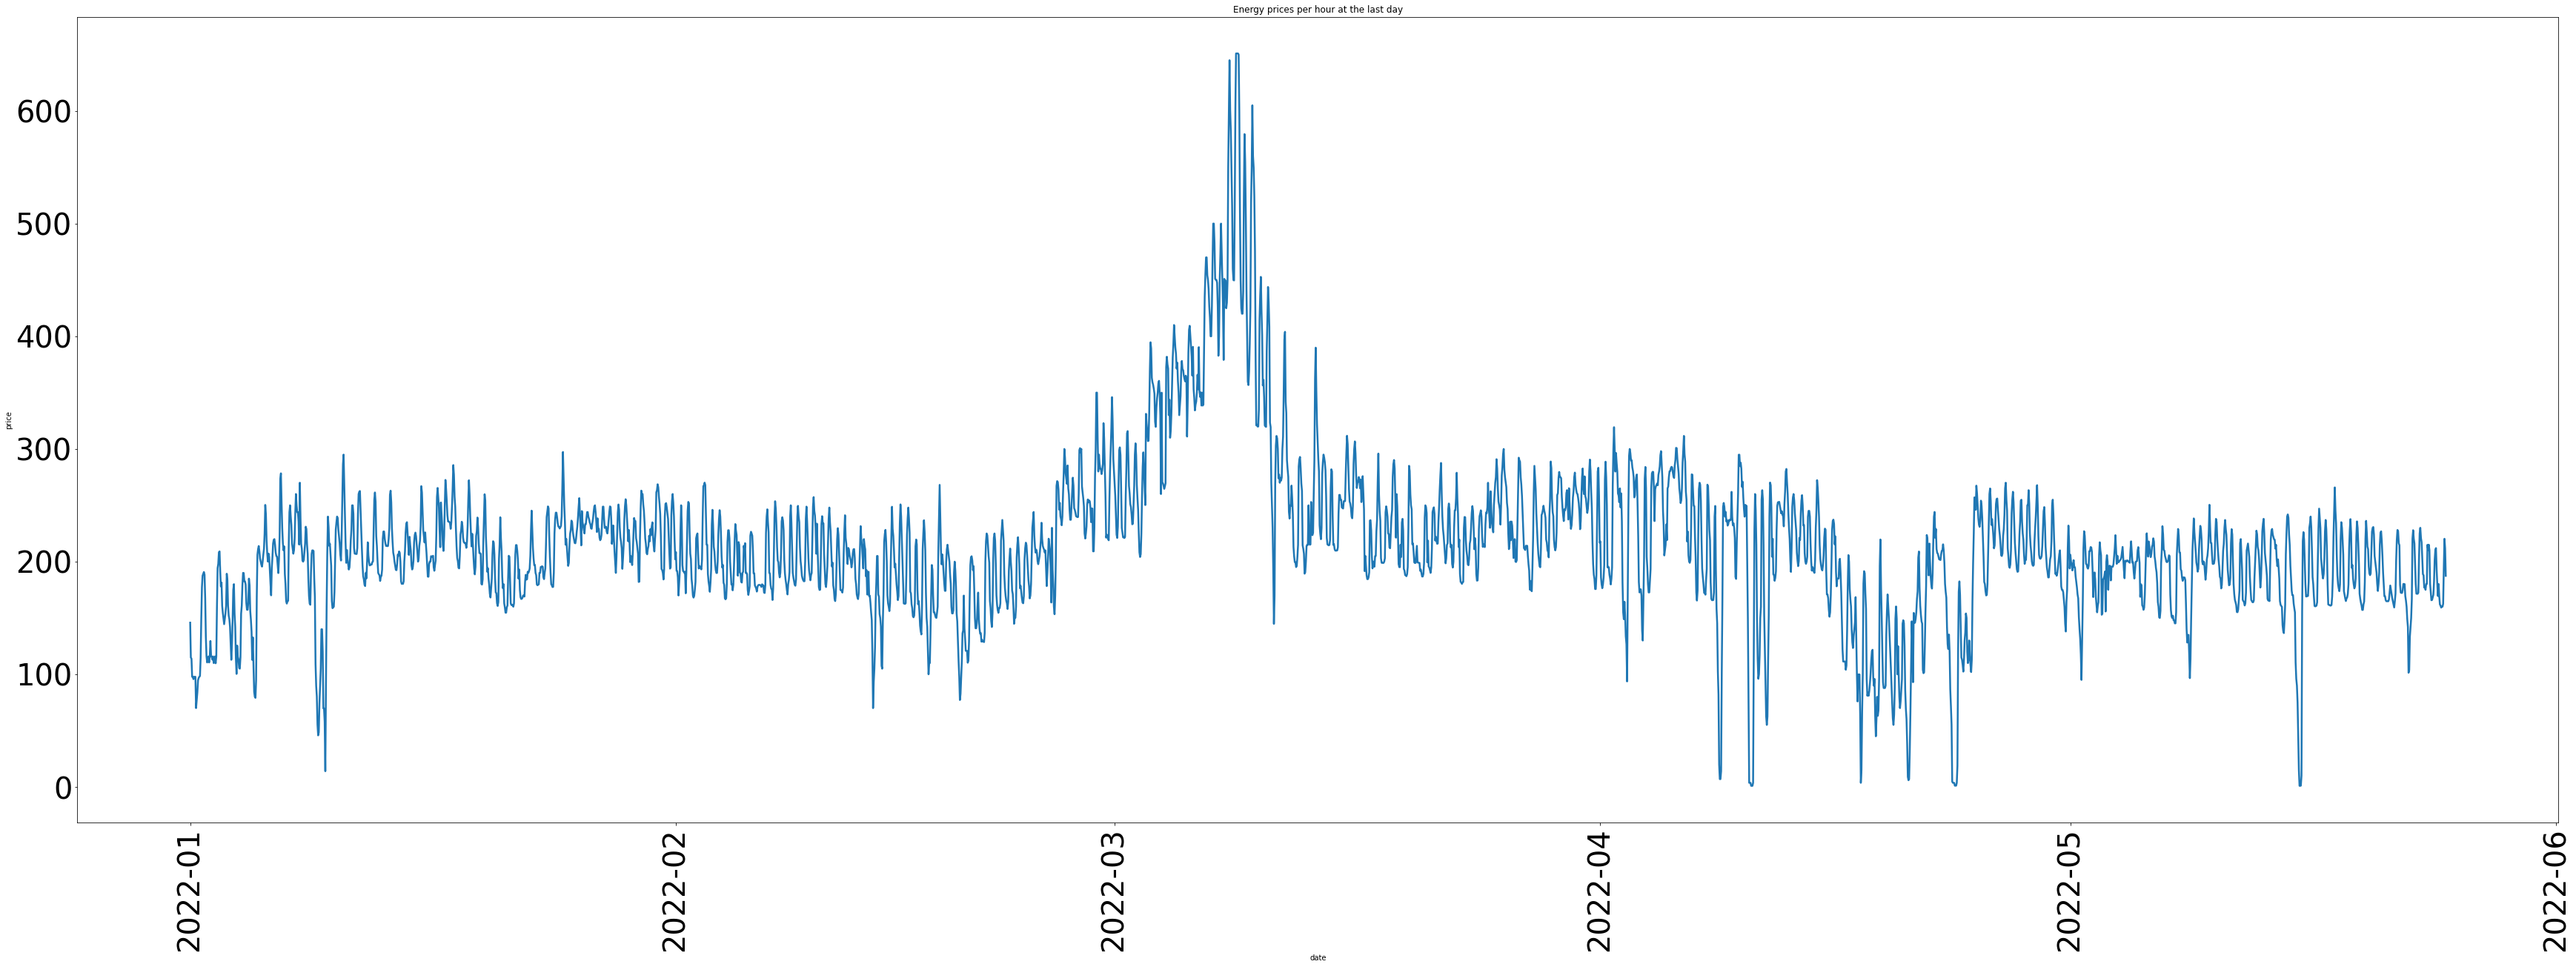

In [11]:
fig, ax = plt.subplots(figsize=(60,20))
plt.xticks(rotation=90, fontsize = 40)
plt.yticks(fontsize = 40)
sns.lineplot(x = 'date', y = 'price', data = df, linewidth = 2.5, ax = ax).set(title='Energy prices per hour at the last day')

In [12]:
df = df[['date', 'price']]

In [13]:
date = df.pop('date')

In [14]:
timestamp = date.map(datetime.datetime.timestamp)

In [15]:
sec_day = 24*60*60
sec_week = 7 * day
sec_year = 365.2425 * day

df['day_sin'] = np.sin(timestamp * (2*np.pi / sec_day))
df['day_cos'] = np.cos(timestamp * (2*np.pi / sec_day))
df['week_sin'] = np.sin(timestamp * (2*np.pi / sec_week))
df['week_cos'] = np.cos(timestamp * (2*np.pi / sec_week))
df['year_sin'] = np.sin(timestamp * (2*np.pi / sec_year))
df['year_cos'] = np.cos(timestamp * (2*np.pi / sec_year))

#Tamaño de ventana (normalmente 3 * salida)
w_size = 3 
#Número de entradas
n_inputs = len(df.columns)

In [16]:
# Método de la ventana, parámetro único en X
# Aquí podemos ver como dadas 5 horas, predice la siguiente
# [[P1, DS1, DC1, YS1, YC1],[P2...],[P3...],[P4...],[P5...] --> [P6]
# [P2,P3,P4,P5,P6] --> [P7]

def df_to_x_y_multiple(df, w_size):
    df_as_np = df.to_numpy()
    x = []
    y = []
    
    #Bucle para construir nuestra ventana simple
    for i in range(len(df_as_np) - w_size):
        row = [r for r in df_as_np[i:i + w_size]]
        x.append(row)
        
        #Solo queremos el precio
        label = df_as_np[i + w_size][0]
        y.append(label)
    
    y_array = np.array(y)
    return np.array(x), y_array.reshape((y_array.size,1))

In [17]:
x, y = df_to_x_y_multiple(df, w_size)
x.shape, y.shape

((3452, 3, 7), (3452, 1))

In [18]:
x_train, x_aux, y_train, y_aux = train_test_split(x, y, test_size = 0.3, shuffle=False)
x_test, x_val, y_test, y_val = train_test_split(x_aux, y_aux, test_size = 0.33, shuffle=False)

In [19]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((2416, 3, 7), (2416, 1), (694, 3, 7), (694, 1), (342, 3, 7), (342, 1))

In [20]:
x_mean = np.mean(x[:, :, 0])
x_std = np.std(x[:, :, 0])
y_mean = np.mean(y[:, 0])
y_std = np.std(y[:, 0])

In [21]:
def standarize_input(df):
    df[:, :, 0] = (df[:, :, 0] - x_mean) / x_std
    return df

def standarize_output(df):
    df[:, 0] = (df[:, 0] - y_mean) / y_std
    return df

In [22]:
x_train_norm = standarize_input(x_train)
x_test_norm = standarize_input(x_test)
x_val_norm = standarize_input(x_val)
y_train_norm = standarize_output(y_train)
y_test_norm = standarize_output(y_test)
y_val_norm = standarize_output(y_val)

In [23]:
def build_model_lstm():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(64))
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [24]:
def build_model_lstm_ret_seq():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(64, return_sequences = True))
    model.add(tf.keras.layers.LSTM(32))
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [25]:
def build_model_cnn():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.Conv1D(64, kernel_size = 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [26]:
def build_model_cnn_relu():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.Conv1D(64, kernel_size = 2, activation = 'relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [27]:
def build_model_gru():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.GRU(64))
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [28]:
def build_model_gru_ret_seq():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.GRU(64, return_sequences = True))
    model.add(tf.keras.layers.GRU(32))
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [29]:
def build_model_lstm_unrestricted():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(64, return_sequences = True))
    model.add(tf.keras.layers.LSTM(32, return_sequences = True))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [30]:
def build_model_lstm_dropout():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(64, return_sequences = True, recurrent_dropout = 0.5))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.LSTM(32, return_sequences = True, recurrent_dropout = 0.5))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [31]:
def build_model_lstm_go_bwd():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(64, return_sequences = True, go_backwards = True))
    model.add(tf.keras.layers.LSTM(32, return_sequences = True))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [32]:
def build_model_lstm_bidirectional():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [33]:
model_lstm = build_model_lstm()
model_cnn = build_model_cnn()
model_gru = build_model_gru()
model_lstm_ret_seq = build_model_lstm_ret_seq()
model_cnn_relu = build_model_cnn_relu()
model_lstm_unrestricted = build_model_lstm_unrestricted()
model_lstm_dropout = build_model_lstm_dropout()
model_lstm_go_bwd = build_model_lstm_go_bwd()
model_lstm_bi = build_model_lstm_bidirectional()

2022-06-22 11:35:42.591392: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-22 11:35:43.732982: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 24607 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:5b:00.0, compute capability: 7.0
2022-06-22 11:35:43.734193: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 28155 MB memory:  -> device: 1, name: Tesla V100-PCIE-32GB, pci bus id: 0000:d7:00.0, compute capability: 7.0


In [34]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='auto', restore_best_weights=True, patience=15)

In [35]:
history_lstm = model_lstm.fit(
    x_train_norm,
    y_train,
    validation_data = (x_val_norm, y_val),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500


2022-06-22 11:35:47.459944: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


76/76 [==============================] - 3s 13ms/step - loss: 0.7228 - mae: 0.5391 - mse: 0.7228 - val_loss: 0.2207 - val_mae: 0.3779 - val_mse: 0.2207
Epoch 2/500
76/76 [==============================] - 1s 9ms/step - loss: 0.3236 - mae: 0.3781 - mse: 0.3236 - val_loss: 0.1257 - val_mae: 0.2488 - val_mse: 0.1257
Epoch 3/500
76/76 [==============================] - 1s 9ms/step - loss: 0.1799 - mae: 0.2939 - mse: 0.1799 - val_loss: 0.0920 - val_mae: 0.1989 - val_mse: 0.0920
Epoch 4/500
76/76 [==============================] - 1s 9ms/step - loss: 0.1399 - mae: 0.2608 - mse: 0.1399 - val_loss: 0.0742 - val_mae: 0.1831 - val_mse: 0.0742
Epoch 5/500
76/76 [==============================] - 1s 9ms/step - loss: 0.1204 - mae: 0.2396 - mse: 0.1204 - val_loss: 0.0684 - val_mae: 0.1855 - val_mse: 0.0684
Epoch 6/500
76/76 [==============================] - 1s 9ms/step - loss: 0.1092 - mae: 0.2284 - mse: 0.1092 - val_loss: 0.0688 - val_mae: 0.1889 - val_mse: 0.0688
Epoch 7/500
76/76 [==============

In [36]:
history_lstm_ret_seq = model_lstm_ret_seq.fit(
    x_train_norm,
    y_train,
    validation_data = (x_val_norm, y_val),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
76/76 [==============================] - 3s 17ms/step - loss: 0.8597 - mae: 0.5873 - mse: 0.8597 - val_loss: 0.3221 - val_mae: 0.4456 - val_mse: 0.3221
Epoch 2/500
76/76 [==============================] - 1s 11ms/step - loss: 0.4204 - mae: 0.4482 - mse: 0.4204 - val_loss: 0.1854 - val_mae: 0.3024 - val_mse: 0.1854
Epoch 3/500
76/76 [==============================] - 1s 12ms/step - loss: 0.2516 - mae: 0.3599 - mse: 0.2516 - val_loss: 0.1516 - val_mae: 0.2756 - val_mse: 0.1516
Epoch 4/500
76/76 [==============================] - 1s 12ms/step - loss: 0.1953 - mae: 0.3149 - mse: 0.1953 - val_loss: 0.1088 - val_mae: 0.2287 - val_mse: 0.1088
Epoch 5/500
76/76 [==============================] - 1s 12ms/step - loss: 0.1563 - mae: 0.2798 - mse: 0.1563 - val_loss: 0.0794 - val_mae: 0.1957 - val_mse: 0.0794
Epoch 6/500
76/76 [==============================] - 1s 10ms/step - loss: 0.1342 - mae: 0.2603 - mse: 0.1342 - val_loss: 0.0763 - val_mae: 0.2006 - val_mse: 0.0763
Epoch 7/500
76/7

In [37]:
history_cnn = model_cnn.fit(
    x_train_norm,
    y_train,
    validation_data = (x_val_norm, y_val),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
76/76 [==============================] - 2s 9ms/step - loss: 0.5156 - mae: 0.4805 - mse: 0.5156 - val_loss: 0.0958 - val_mae: 0.2338 - val_mse: 0.0958
Epoch 2/500
76/76 [==============================] - 1s 7ms/step - loss: 0.1572 - mae: 0.2787 - mse: 0.1572 - val_loss: 0.0622 - val_mae: 0.1722 - val_mse: 0.0622
Epoch 3/500
76/76 [==============================] - 1s 7ms/step - loss: 0.1289 - mae: 0.2520 - mse: 0.1289 - val_loss: 0.0607 - val_mae: 0.1707 - val_mse: 0.0607
Epoch 4/500
76/76 [==============================] - 1s 7ms/step - loss: 0.1070 - mae: 0.2259 - mse: 0.1070 - val_loss: 0.0574 - val_mae: 0.1723 - val_mse: 0.0574
Epoch 5/500
76/76 [==============================] - 1s 7ms/step - loss: 0.0855 - mae: 0.2014 - mse: 0.0855 - val_loss: 0.0497 - val_mae: 0.1631 - val_mse: 0.0497
Epoch 6/500
76/76 [==============================] - 1s 7ms/step - loss: 0.0754 - mae: 0.1900 - mse: 0.0754 - val_loss: 0.0466 - val_mae: 0.1622 - val_mse: 0.0466
Epoch 7/500
76/76 [===

In [38]:
history_cnn_relu = model_cnn_relu.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
76/76 [==============================] - 1s 7ms/step - loss: 0.7197 - mae: 0.5438 - mse: 0.7197 - val_loss: 0.1692 - val_mae: 0.3194 - val_mse: 0.1692
Epoch 2/500
76/76 [==============================] - 0s 6ms/step - loss: 0.2820 - mae: 0.3506 - mse: 0.2820 - val_loss: 0.0937 - val_mae: 0.2211 - val_mse: 0.0937
Epoch 3/500
76/76 [==============================] - 0s 6ms/step - loss: 0.1171 - mae: 0.2425 - mse: 0.1171 - val_loss: 0.0665 - val_mae: 0.1863 - val_mse: 0.0665
Epoch 4/500
76/76 [==============================] - 0s 6ms/step - loss: 0.1093 - mae: 0.2397 - mse: 0.1093 - val_loss: 0.0625 - val_mae: 0.1906 - val_mse: 0.0625
Epoch 5/500
76/76 [==============================] - 0s 6ms/step - loss: 0.0851 - mae: 0.2076 - mse: 0.0851 - val_loss: 0.0565 - val_mae: 0.1755 - val_mse: 0.0565
Epoch 6/500
76/76 [==============================] - 0s 6ms/step - loss: 0.0941 - mae: 0.2222 - mse: 0.0941 - val_loss: 0.0541 - val_mae: 0.1793 - val_mse: 0.0541
Epoch 7/500
76/76 [===

In [39]:
history_gru = model_gru.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
76/76 [==============================] - 2s 13ms/step - loss: 0.4126 - mae: 0.4254 - mse: 0.4126 - val_loss: 0.1147 - val_mae: 0.2472 - val_mse: 0.1147
Epoch 2/500
76/76 [==============================] - 1s 9ms/step - loss: 0.1633 - mae: 0.2778 - mse: 0.1633 - val_loss: 0.0803 - val_mae: 0.1804 - val_mse: 0.0803
Epoch 3/500
76/76 [==============================] - 1s 9ms/step - loss: 0.1123 - mae: 0.2327 - mse: 0.1123 - val_loss: 0.0618 - val_mae: 0.1696 - val_mse: 0.0618
Epoch 4/500
76/76 [==============================] - 1s 9ms/step - loss: 0.0858 - mae: 0.2015 - mse: 0.0858 - val_loss: 0.0569 - val_mae: 0.1684 - val_mse: 0.0569
Epoch 5/500
76/76 [==============================] - 1s 9ms/step - loss: 0.0758 - mae: 0.1918 - mse: 0.0758 - val_loss: 0.0534 - val_mae: 0.1730 - val_mse: 0.0534
Epoch 6/500
76/76 [==============================] - 1s 9ms/step - loss: 0.0688 - mae: 0.1840 - mse: 0.0688 - val_loss: 0.0506 - val_mae: 0.1695 - val_mse: 0.0506
Epoch 7/500
76/76 [==

In [40]:
history_lstm_unrestricted = model_lstm_unrestricted.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
76/76 [==============================] - 4s 19ms/step - loss: 0.8245 - mae: 0.5792 - mse: 0.8245 - val_loss: 0.2426 - val_mae: 0.4007 - val_mse: 0.2426
Epoch 2/500
76/76 [==============================] - 1s 11ms/step - loss: 0.4110 - mae: 0.4455 - mse: 0.4110 - val_loss: 0.1855 - val_mae: 0.3066 - val_mse: 0.1855
Epoch 3/500
76/76 [==============================] - 1s 11ms/step - loss: 0.2606 - mae: 0.3623 - mse: 0.2606 - val_loss: 0.1567 - val_mae: 0.2779 - val_mse: 0.1567
Epoch 4/500
76/76 [==============================] - 1s 11ms/step - loss: 0.2009 - mae: 0.3159 - mse: 0.2009 - val_loss: 0.1326 - val_mae: 0.2575 - val_mse: 0.1326
Epoch 5/500
76/76 [==============================] - 1s 11ms/step - loss: 0.1715 - mae: 0.2912 - mse: 0.1715 - val_loss: 0.1081 - val_mae: 0.2220 - val_mse: 0.1081
Epoch 6/500
76/76 [==============================] - 1s 11ms/step - loss: 0.1578 - mae: 0.2836 - mse: 0.1578 - val_loss: 0.0972 - val_mae: 0.2089 - val_mse: 0.0972
Epoch 7/500
76/7

In [41]:
history_lstm_dropout = model_lstm_dropout.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
76/76 [==============================] - 6s 43ms/step - loss: 0.8045 - mae: 0.5756 - mse: 0.8045 - val_loss: 0.2443 - val_mae: 0.4010 - val_mse: 0.2443
Epoch 2/500
76/76 [==============================] - 3s 38ms/step - loss: 0.4206 - mae: 0.4514 - mse: 0.4206 - val_loss: 0.1868 - val_mae: 0.3132 - val_mse: 0.1868
Epoch 3/500
76/76 [==============================] - 3s 39ms/step - loss: 0.2993 - mae: 0.3843 - mse: 0.2993 - val_loss: 0.1684 - val_mae: 0.2975 - val_mse: 0.1684
Epoch 4/500
76/76 [==============================] - 3s 39ms/step - loss: 0.2555 - mae: 0.3577 - mse: 0.2555 - val_loss: 0.1569 - val_mae: 0.2947 - val_mse: 0.1569
Epoch 5/500
76/76 [==============================] - 3s 40ms/step - loss: 0.2312 - mae: 0.3344 - mse: 0.2312 - val_loss: 0.1362 - val_mae: 0.2674 - val_mse: 0.1362
Epoch 6/500
76/76 [==============================] - 3s 40ms/step - loss: 0.2135 - mae: 0.3247 - mse: 0.2135 - val_loss: 0.1081 - val_mae: 0.2178 - val_mse: 0.1081
Epoch 7/500
76/7

In [42]:
history_lstm_go_bwd = model_lstm_go_bwd.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
76/76 [==============================] - 3s 19ms/step - loss: 0.6554 - mae: 0.5048 - mse: 0.6554 - val_loss: 0.1059 - val_mae: 0.2484 - val_mse: 0.1059
Epoch 2/500
76/76 [==============================] - 1s 11ms/step - loss: 0.2371 - mae: 0.3167 - mse: 0.2371 - val_loss: 0.1125 - val_mae: 0.2376 - val_mse: 0.1125
Epoch 3/500
76/76 [==============================] - 1s 12ms/step - loss: 0.1473 - mae: 0.2613 - mse: 0.1473 - val_loss: 0.0929 - val_mae: 0.1895 - val_mse: 0.0929
Epoch 4/500
76/76 [==============================] - 1s 12ms/step - loss: 0.1186 - mae: 0.2373 - mse: 0.1186 - val_loss: 0.0791 - val_mae: 0.1754 - val_mse: 0.0791
Epoch 5/500
76/76 [==============================] - 1s 11ms/step - loss: 0.1056 - mae: 0.2218 - mse: 0.1056 - val_loss: 0.0657 - val_mae: 0.1589 - val_mse: 0.0657
Epoch 6/500
76/76 [==============================] - 1s 11ms/step - loss: 0.0949 - mae: 0.2121 - mse: 0.0949 - val_loss: 0.0585 - val_mae: 0.1555 - val_mse: 0.0585
Epoch 7/500
76/7

In [43]:
history_lstm_bi = model_lstm_bi.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
76/76 [==============================] - 6s 28ms/step - loss: 0.5493 - mae: 0.5054 - mse: 0.5493 - val_loss: 0.1697 - val_mae: 0.3087 - val_mse: 0.1697
Epoch 2/500
76/76 [==============================] - 1s 15ms/step - loss: 0.2210 - mae: 0.3295 - mse: 0.2210 - val_loss: 0.1269 - val_mae: 0.2463 - val_mse: 0.1269
Epoch 3/500
76/76 [==============================] - 1s 15ms/step - loss: 0.1509 - mae: 0.2757 - mse: 0.1509 - val_loss: 0.0927 - val_mae: 0.2045 - val_mse: 0.0927
Epoch 4/500
76/76 [==============================] - 1s 15ms/step - loss: 0.1308 - mae: 0.2531 - mse: 0.1308 - val_loss: 0.0716 - val_mae: 0.1687 - val_mse: 0.0716
Epoch 5/500
76/76 [==============================] - 1s 16ms/step - loss: 0.1187 - mae: 0.2427 - mse: 0.1187 - val_loss: 0.0644 - val_mae: 0.1624 - val_mse: 0.0644
Epoch 6/500
76/76 [==============================] - 1s 15ms/step - loss: 0.1106 - mae: 0.2369 - mse: 0.1106 - val_loss: 0.0589 - val_mae: 0.1598 - val_mse: 0.0589
Epoch 7/500
76/7

In [44]:
def plot_history(history, y_min, y_loss, y_mae, y_mse):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    #Graphic of Loss
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss Function')
    plt.plot(hist['epoch'], hist['loss'], label='Loss Error')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    plt.ylim([y_min,y_loss])
    plt.legend()
    
    #Graphic of MAE
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.ylim([y_min,y_mae])
    plt.legend()
    
    #Graphic of MSE
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.ylim([y_min,y_mse])
    plt.legend()
    
    
    plt.show()

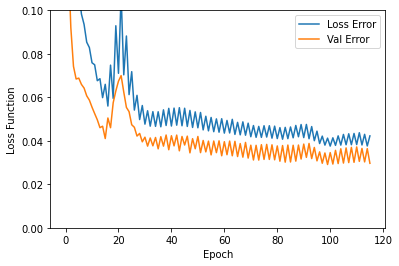

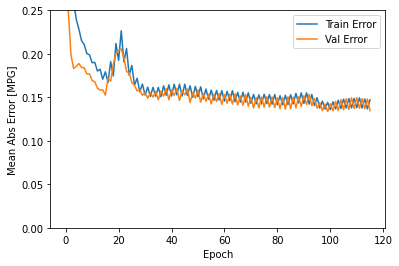

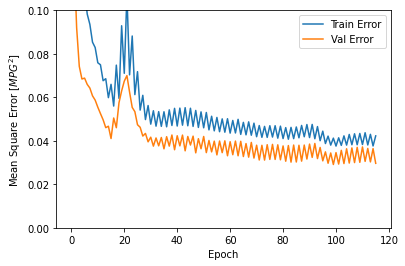

In [45]:
plot_history(history_lstm, 0, 0.1, 0.25, 0.1)

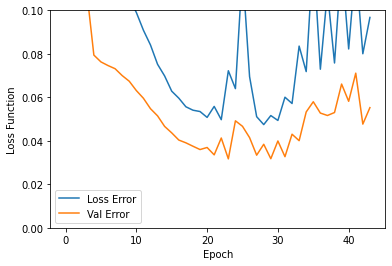

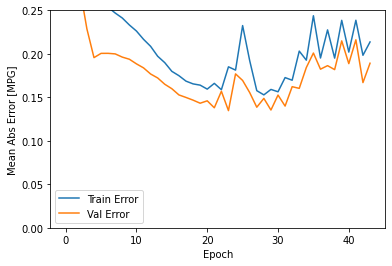

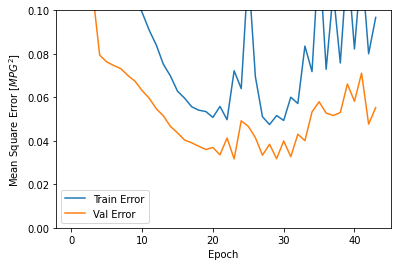

In [46]:
plot_history(history_lstm_ret_seq, 0, 0.1, 0.25, 0.1)

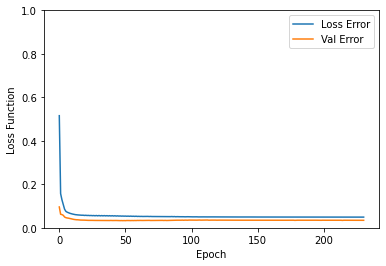

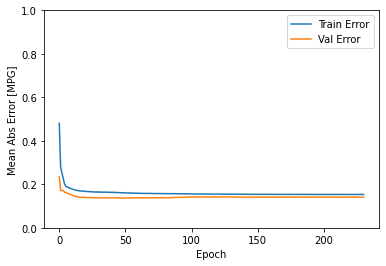

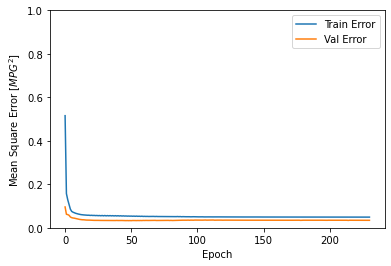

In [47]:
plot_history(history_cnn, 0, 1, 1, 1)

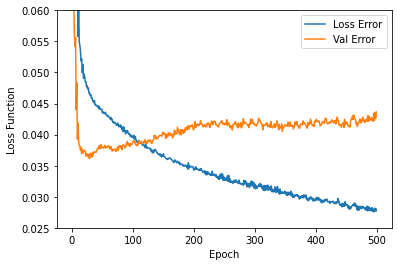

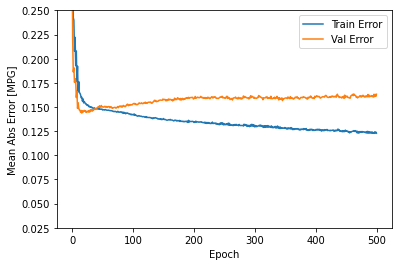

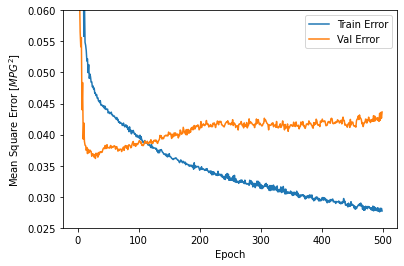

In [48]:
plot_history(history_cnn_relu, 0.025, 0.06, 0.25, 0.06)

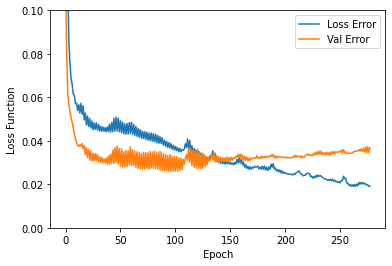

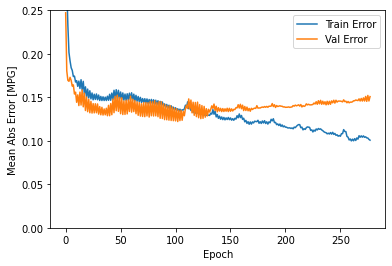

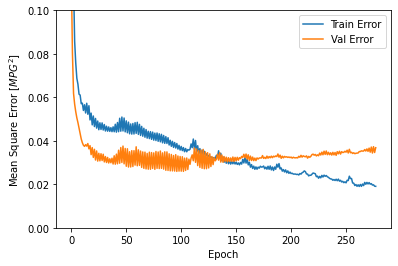

In [49]:
plot_history(history_gru, 0, 0.1, 0.25, 0.1)

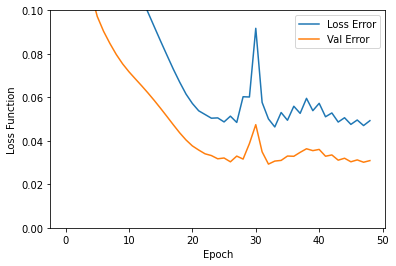

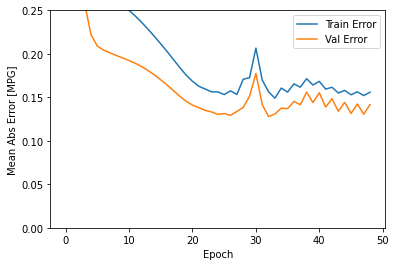

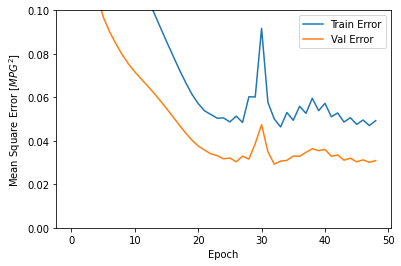

In [50]:
plot_history(history_lstm_unrestricted, 0, 0.1, 0.25, 0.1)

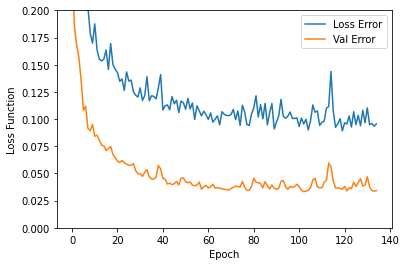

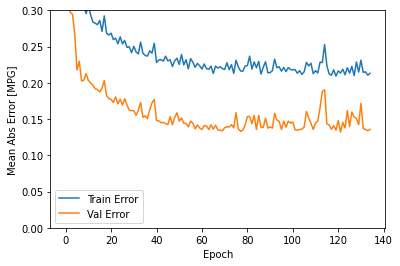

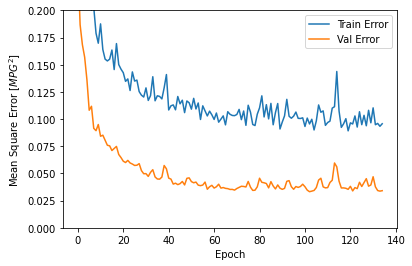

In [51]:
plot_history(history_lstm_dropout, 0, 0.2, 0.3, 0.2)

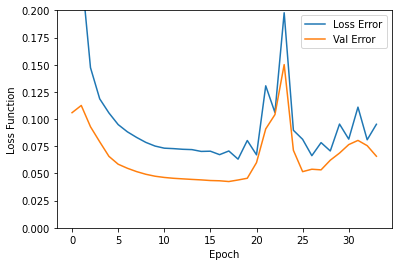

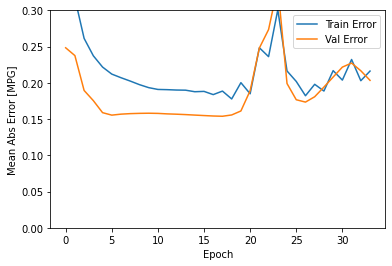

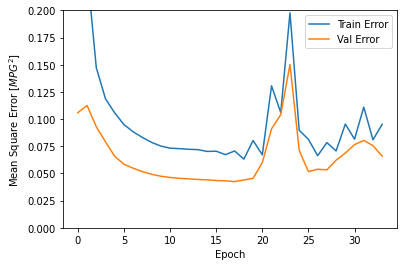

In [52]:
plot_history(history_lstm_go_bwd, 0, 0.2, 0.3, 0.2)

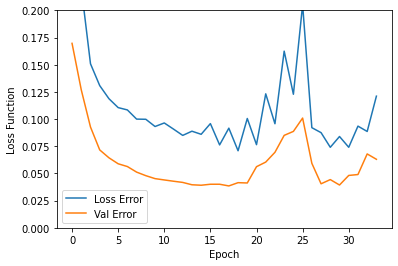

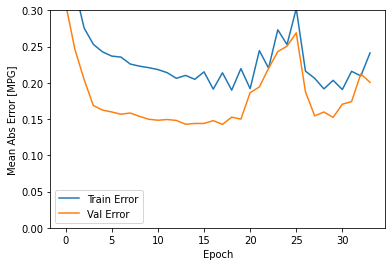

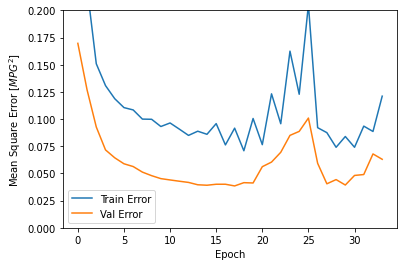

In [53]:
plot_history(history_lstm_bi, 0, 0.2, 0.3, 0.2)

In [54]:
y_pred_lstm = model_lstm.predict(x_test_norm)
y_pred_gru = model_gru.predict(x_test_norm)
y_pred_lstm_ret_seq = model_lstm_ret_seq.predict(x_test_norm)
y_pred_cnn_relu = model_cnn_relu.predict(x_test_norm)

In [55]:
y_pred_cnn = model_cnn.predict(x_test_norm)

In [56]:
y_pred_lstm_unrestricted = model_lstm_unrestricted.predict(x_test_norm)

In [57]:
y_pred_lstm_dropout = model_lstm_dropout.predict(x_test_norm)

In [58]:
y_pred_lstm_go_bwd = model_lstm_go_bwd.predict(x_test_norm)

In [59]:
y_pred_lstm_bi = model_lstm_bi.predict(x_test_norm)

In [60]:
def inverse_standarize_input(arr):
    arr = (arr * y_std) + y_mean
    return arr

In [61]:
y_pred_lstm = inverse_standarize_input(y_pred_lstm)
y_pred_gru = inverse_standarize_input(y_pred_gru)
y_pred_lstm_ret_seq = inverse_standarize_input(y_pred_lstm_ret_seq)
y_pred_cnn_relu = inverse_standarize_input(y_pred_cnn_relu)
y_test = inverse_standarize_input(y_test_norm)

In [62]:
y_pred_cnn = inverse_standarize_input(y_pred_cnn)

In [63]:
y_pred_lstm_unrestricted = inverse_standarize_input(y_pred_lstm_unrestricted)

In [64]:
y_pred_lstm_bi = inverse_standarize_input(y_pred_lstm_bi)

In [65]:
y_pred_lstm_dropout = inverse_standarize_input(y_pred_lstm_dropout)

In [66]:
y_pred_lstm_go_bwd = inverse_standarize_input(y_pred_lstm_go_bwd)

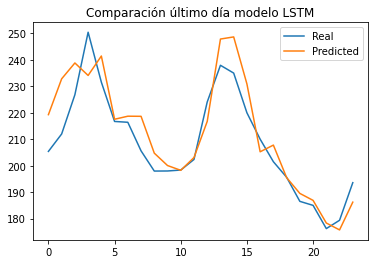

In [67]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_lstm[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo LSTM")
plt.legend()

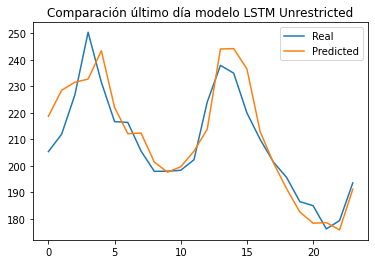

In [68]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_lstm_unrestricted[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo LSTM Unrestricted")
plt.legend()

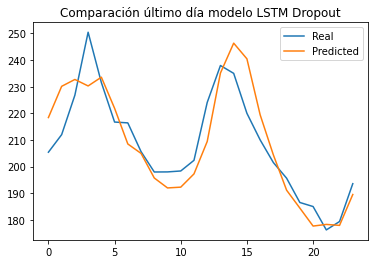

In [69]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_lstm_dropout[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo LSTM Dropout")
plt.legend()

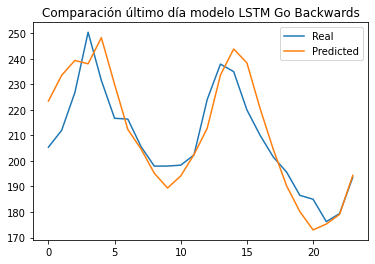

In [70]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_lstm_go_bwd[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo LSTM Go Backwards")
plt.legend()

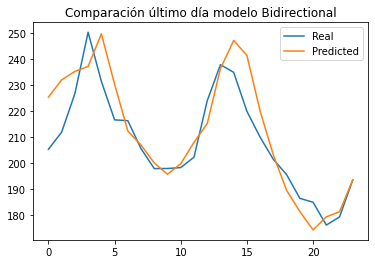

In [71]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_lstm_bi[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo Bidirectional")
plt.legend()

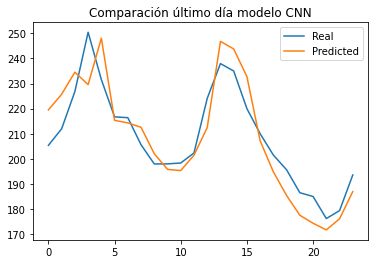

In [72]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_cnn[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo CNN")
plt.legend()

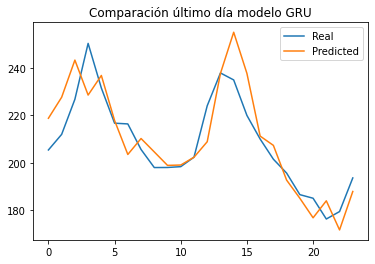

In [73]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_gru[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo GRU")
plt.legend()

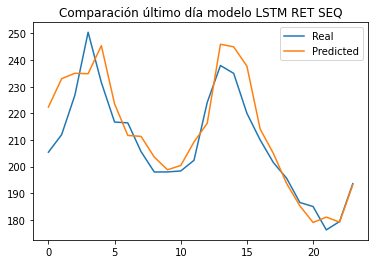

In [74]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_lstm_ret_seq[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo LSTM RET SEQ")
plt.legend()

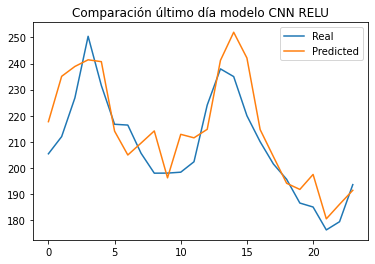

In [75]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_cnn_relu[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo CNN RELU")
plt.legend()

In [76]:
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_cnn = np.sqrt(mean_squared_error(y_test, y_pred_cnn))
mae_cnn = mean_absolute_error(y_test, y_pred_cnn)
rmse_gru = np.sqrt(mean_squared_error(y_test, y_pred_gru))
mae_gru = mean_absolute_error(y_test, y_pred_gru)
rmse_lstm_ret_seq = np.sqrt(mean_squared_error(y_test, y_pred_lstm_ret_seq))
mae_lstm_ret_seq = mean_absolute_error(y_test, y_pred_lstm_ret_seq)
rmse_cnn_relu = np.sqrt(mean_squared_error(y_test, y_pred_cnn_relu))
mae_cnn_relu = mean_absolute_error(y_test, y_pred_cnn_relu)
rmse_lstm_unrestricted = np.sqrt(mean_squared_error(y_test, y_pred_lstm_unrestricted))
mae_lstm_unrestricted = mean_absolute_error(y_test, y_pred_lstm_unrestricted)
rmse_lstm_dropout = np.sqrt(mean_squared_error(y_test, y_pred_lstm_dropout))
mae_lstm_dropout = mean_absolute_error(y_test, y_pred_lstm_dropout)
rmse_lstm_go_bwd = np.sqrt(mean_squared_error(y_test, y_pred_lstm_go_bwd))
mae_lstm_go_bwd = mean_absolute_error(y_test, y_pred_lstm_go_bwd)
rmse_lstm_bi = np.sqrt(mean_squared_error(y_test, y_pred_lstm_bi))
mae_lstm_bi = mean_absolute_error(y_test, y_pred_lstm_bi)

In [77]:
print("RMSE LSTM BI: " + str(rmse_lstm_bi))
print("RMSE LSTM UNR: " + str(rmse_lstm_unrestricted))

RMSE LSTM BI: 15.847617262710285
RMSE LSTM UNR: 14.843261275126427


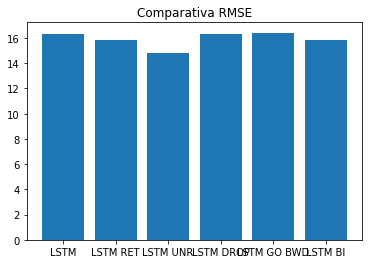

In [78]:
x_axis = ["LSTM", "LSTM RET", "LSTM UNR", "LSTM DROP", "LSTM GO BWD", "LSTM BI"]
y_axis = [rmse_lstm, rmse_lstm_ret_seq, rmse_lstm_unrestricted, rmse_lstm_dropout, rmse_lstm_go_bwd, rmse_lstm_bi]
plt.title("Comparativa RMSE")
plt.bar(x_axis, y_axis)
plt.show()

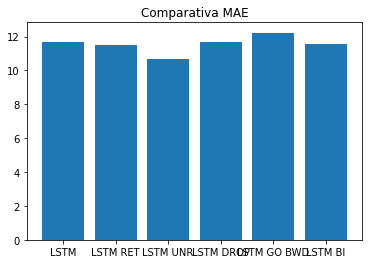

In [79]:
x_axis = ["LSTM", "LSTM RET", "LSTM UNR", "LSTM DROP", "LSTM GO BWD", "LSTM BI"]
y_axis = [mae_lstm, mae_lstm_ret_seq, mae_lstm_unrestricted, mae_lstm_dropout, mae_lstm_go_bwd, mae_lstm_bi]
plt.title("Comparativa MAE")
plt.bar(x_axis, y_axis)
plt.show()

In [80]:
model_lstm.save("normalized_multiple_input_2022/LSTM.h5")
model_cnn.save("normalized_multiple_input_2022/CNN.h5")
model_gru.save("normalized_multiple_input_2022/GRU.h5")
model_lstm_ret_seq.save("normalized_multiple_input_2022/LSTM_RET_SEQ.h5")
model_cnn_relu.save("normalized_multiple_input_2022/CNN_RELU.h5")
model_lstm_unrestricted.save("normalized_multiple_input_2022/LSTM_UNRESTRICTED.h5")
model_lstm_dropout.save("normalized_multiple_input_2022/LSTM_DROPOUT.h5")
model_lstm_go_bwd.save("normalized_multiple_input_2022/LSTM_GO_BWD.h5")
model_lstm_bi.save("normalized_multiple_input_2022/LSTM_BI.h5")

In [81]:
# saved_model_lstm_unr = tf.keras.models.load_model("normalized_multiple_input_2022/LSTM_UNRESTRICTED.h5")

In [82]:
# tf.saved_model.save(saved_model_lstm_unr, "/models")
model_lstm_unrestricted.save("prueba")

2022-06-22 11:56:13.613422: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: prueba/assets


INFO:tensorflow:Assets written to: prueba/assets
